In [1]:
# The basics and needed libraries and dependenices
%matplotlib inline
import matplotlib.pyplot as plt
import time
import itertools
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from collections import deque

import numpy as np
import sys
import os
import random
from collections import namedtuple
import collections
import copy

# Import the open AI gym and its overrided environment
import gym
import virl 
# Keras and backend for neural networks
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K
import tensorflow as tf
import sklearn.preprocessing
import sklearn.pipeline
from sklearn.kernel_approximation import RBFSampler

import pandas as pd

# Misc
import warnings
warnings.filterwarnings('ignore')

print(sys.version)
print(os.path)
print("Keras: ",keras.__version__)
print("TF: ",tf.__version__)


3.8.3 (default, Jul  2 2020, 11:26:31) 
[Clang 10.0.0 ]
<module 'posixpath' from '/opt/anaconda3/lib/python3.8/posixpath.py'>
Keras:  2.4.3
TF:  2.3.1


####  Mingfeng YE : Help function to see the converge

In [2]:

def plot_episode_stats(stats, smoothing_window, environment,noisy, noshow=False):
    #Plot the episode length over time
#     fig1 = plt.figure(figsize=(10,5))
#     plt.plot(stats.episode_lengths)
#     plt.xlabel("Episode")
#     plt.ylabel("Episode Length")
#     plt.title("Episode Length over Time")
#     plt.grid(True)
    
    #Plot the episode reward over time
    
    fig1 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    plt.savefig('graphs/qlearnnn/converge graph/average performance vs number of episodes'+ "for qlearnnn agent" + " " + environment + " " + noisy + " "+ '.png')
    plt.grid(True)
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)
    return fig1

#### Mingfeng YE : Initialze Environment for observation purpose

In [3]:
env = virl.Epidemic(problem_id=0,noisy=False)
env.observation_space.sample()

array([1.66854328, 3.52588921, 2.87531483, 1.82909326])

#### Mingfeng YE : Define the eural network Function Approximations

In [4]:
class NNFunctionApproximator():
   
    
    def __init__(self, alpha, d_states, n_actions, nn_config, verbose=False):        
        self.alpha = alpha    
        self.nn_config = nn_config      # determines the size of the hidden layer (if any)             
        self.n_actions = n_actions        
        self.d_states = d_states
        self.verbose=verbose # Print debug information        
        self.n_layers = len(nn_config)                
        self.model = self._build_model()                
                        
    def _huber_loss(self,y_true, y_pred, clip_delta=1.0):
        """
        Huber loss (for use in Keras), see https://en.wikipedia.org/wiki/Huber_loss
        The huber loss tends to provide more robust learning in RL settings where there are 
        often "outliers" before the functions has converged.
        """
        error = y_true - y_pred
        cond  = K.abs(error) <= clip_delta
        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)
        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

        
        return scaled
    def _build_model(self):
        # Neural Net for Deep-Q learning 
        model = Sequential()
        for ilayer in self.nn_config:
            model.add(Dense(ilayer, input_dim=self.d_states, activation='relu'))        
        model.add(Dense(self.n_actions, activation='linear'))
        model.compile(loss=self._huber_loss, # define a special loss function
                      optimizer=Adam(lr=self.alpha, clipnorm=10.)) # specify the optimiser, we clip the gradient of the norm which can make traning more robust
        return model

    def predict(self, s, a=None):              
        if a==None:            
            return self._predict_nn(s)
        else:                        
            return self._predict_nn(s)[a]
        
    def _predict_nn(self,state_hat):                          
        """
        Predict the output of the neural netwwork (note: these can be vectors)
        """                
        x = self.model.predict(state_hat)                                                    
        return x
  
    def update(self, states, td_target):           
        self.model.fit(states, td_target, epochs=1, verbose=0) # take one gradient step usign Adam               
        return 

####  A Q-learning Agent

In [5]:

# Keep track of some stats
EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

# Main Q-learner
def q_learning_nn(env, func_approximator, func_approximator_target, num_episodes,BATCH_SIZE,BUFFER_SIZE,max_steps_per_episode=500,discount_factor=0.99, epsilon_init=0.01, epsilon_decay=0.99995,epsilon_min=0.01,use_batch_updates=True,fn_model_in=None, fn_model_out=None):
    """
    Q-Learning algorithm for Q-learning using Function Approximations.
    Finds the optimal greedy policy while following an explorative greedy policy.
    
    Args:
        env: virl environment.
        func_approximator: Action-Value function estimator, behavior policy (i.e. the function which determines the next action)
        func_approximator_target: Action-Value function estimator, updated less frequenty than the behavior policy 
        num_episodes: Number of episodes to run for.
        max_steps_per_episode: Max number of steps per episodes - 52 weeks
        discount_factor: Gamma discount factor.
        epsilon_init: Exploration strategy; chance the sample a random action. Float between 0 and 1.
        epsilon_decay: Each episode, epsilon is decayed by this factor
        epislon_min: Min epsilon value        
        use_batch_updates=True, 
        
        fn_model_in: Load the model from the file if not None
        fn_model_out: File name of the saved model, saves the best model in the last 100 episodes

    Returns:
        An EpisodeStats object with two numpy arrays for episode_step and episode_rewards.
    """
   
    
    memory = ReplayMemory(BUFFER_SIZE) # init the replay memory    
    n_actions = env.action_space.n        
    d_states  = env.observation_space.shape[0]    
    best_reward = -10
    states = []
    rewards = []
    actions = []

    # Synch the target and behavior network
    if not fn_model_in is None:
        func_approximator.model.load_weights(fn_model_in)
    func_approximator_target.model.set_weights(func_approximator.model.get_weights())

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes),)            

    epsilon = epsilon_init

    for i_episode in range(num_episodes):
        sys.stdout.flush()
               
        # Reset the environment and pick the first action
        state = env.reset()
        if num_episodes == 1:
            states.append(state)
        state = np.reshape(state, [1, d_states]) # reshape to the a 1xd_state numpy array
        #print(best_reward)
        # One step in the environment
        for t in itertools.count():#range(max_steps_per_episode):#itertools.count():
             
            
            # Select an action usign and epsilon greedy policy based on the main behavior network
            if np.random.rand() <= epsilon:
                action = random.randrange(n_actions)
            else:
                act_values = func_approximator.predict(state)[0]
                action = np.argmax(act_values)  # returns action 
                
            
            # Take a step            
            next_state, reward, done, _ = env.step(action)
            if num_episodes == 1:
                states.append(next_state)
                rewards.append(reward)
                actions.append(action)  
            next_state = np.reshape(next_state, [1, d_states] )
            
            
            
            ## need to rescale the reward to a positve number, so that the traing is better.
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            if reward < -0.05:#done and stats.episode_rewards[i_episode] < best_reward:
                #done = True
                memory.push(state, action, next_state, reward, 0.0)
#             elif done and t < 50:
#                 memory.push(state, action, next_state, reward, 0.0)
#                 stats.episode_rewards[i_episode] = None
            else:
                memory.push(state, action, next_state, reward, 1.0)
            # since the done state is not related the bad action or good action, it episode size is 52 fixed, use 
            # the threshold of reward as a meaningful done state .
#             if stats.episode_rewards[i_episode] < best_reward:
#                 done = True
#                 memory.push(state, action, next_state, reward, 0.0)
            # Update network (if learning is on, i.e. alpha>0 and we have enough samples in memory)
            if func_approximator.alpha > 0.0 and len(memory) >= BATCH_SIZE:
                
                # Fetch a bacth from the replay buffer and extract as numpy arrays 
                transitions = memory.sample(BATCH_SIZE)            
                batch = Transition(*zip(*transitions))                                
                train_rewards = np.array(batch.reward)
               
                train_states = np.array(batch.state)
                train_next_state = np.array(batch.next_state)
                train_actions = np.array(batch.action)
                train_is_not_terminal_state = np.array(batch.is_not_terminal_state) # 
                                
                if(use_batch_updates):
                
                    # Do a single gradient step computed based on the full batch
                    train_td_targets    = func_approximator.predict(train_states.reshape(BATCH_SIZE,4)) # predict current values for the given states
                    q_values_next       = func_approximator_target.predict(np.array(batch.next_state).reshape(BATCH_SIZE,d_states))                    
                    train_td_targetstmp = train_rewards + discount_factor *  train_is_not_terminal_state * np.amax(q_values_next,axis=1)                
                    train_td_targets[ (np.arange(BATCH_SIZE), train_actions.reshape(BATCH_SIZE,).astype(int))] = train_td_targetstmp                                                                              
                    func_approximator.update(train_states.reshape(BATCH_SIZE,d_states), train_td_targets) # Update the function approximator using our target       
                else:
                    #print(5)
                    # Do update in a truely online sense where a gradient step is performaed per observation
                    for s in range(train_rewards.shape[0]):                        
                        target = func_approximator.predict(train_states[s])[0]
                        q_next = func_approximator_target.predict(train_next_state[s])[0]
                        target[train_actions[s]] = train_rewards[s] + discount_factor * train_is_not_terminal_state[s] * np.amax(q_next)                        
                        func_approximator.update(train_states[s], target.reshape(1,n_actions)) # Update the function approximator using our target                                            
                if epsilon > epsilon_min:
                    epsilon *= epsilon_decay
          
            state = next_state                
            
 
            if done:
                
                #Synch the target and behavior network
                func_approximator_target.model.set_weights(func_approximator.model.get_weights())           
                print("\rStep {} @ Episode {}/{} ({})".format(
                        t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1])
                # Save the best model so far    
                if fn_model_out is not None and (stats.episode_rewards[i_episode] >= best_reward and t > 50):
                    # the best model should be the model that could gain more episode rewards at a episode 
                    func_approximator.model.save_weights(fn_model_out)
                    best_reward = stats.episode_rewards[i_episode]
                    
                
                break
    if num_episodes == 1:
        return states,rewards,actions
    else:
        return stats

#### Mingfeng YE : Replay memory for DQN

In [6]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward','is_not_terminal_state'))

class ReplayMemory():
    """
    Implement a replay buffer using the deque collection
    """

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)               

    def push(self, *args):
        """Saves a transition."""
        self.memory.append(Transition(*args))

    def pop(self):
        return self.memoery.pop()

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)   

    def __len__(self):
        return len(self.memory)

#### First : make the function to show the action content

In [7]:
def show_action(actions):
    outcome = " " 
    for i in range(len(actions)):
        outcome += ("week " + str("{:2}".format(i+1)) + " : ")
        if actions[i] == 0:
            outcome += ("%-17s" %("None"))
        if actions[i] == 1:
            outcome += ("%-17s" %("Full Lockdown"))
        if actions[i] == 2:
            outcome += ("%-17s" %("Track & Trace"))
        if actions[i] == 3:
            outcome += ("%-17s" %("Social Distancing"))
        if len(actions) - 1 != i:
            outcome += (" -> ")
        if (i+1) % 4 == 0:
            outcome += "\n"
    return outcome

#### Second : make the function to run one episode with the trained agent 

In [8]:
def run_one_episode(env,nn_func_approximator,nn_func_approximator_target,BATCH_SIZE,BUFFER_SIZE,environment,noisy):
    
    nn_func_approximator.alpha=0.0
    epsilon_fixed = 0.0
    states,rewards,actions = q_learning_nn(env,nn_func_approximator, nn_func_approximator_target, 1,BATCH_SIZE,BUFFER_SIZE,max_steps_per_episode=55, 
                           epsilon_init=epsilon_fixed, epsilon_decay=1.0, epsilon_min=epsilon_fixed, 
                           fn_model_in="virl_temp.h1")    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    # This is the place for visualizing the policy
    print("\n")
    print(show_action(actions))
    labels = ['s[0]: susceptibles', 's[1]: infectious', 's[2]: quarantined', 's[3]: recovereds']
    states = np.array(states)
    
    for i in range(4):
        axes[0].set_title("The states analysis for" + " " + environment + " " + noisy + " " + "for qlearnnn")
        axes[0].plot(states[:,i], label=labels[i]);
        axes[0].set_xlabel('weeks since start of epidemic')
        axes[0].set_ylabel('State s(t)')
        axes[0].legend()
        axes[1].plot(rewards);
        axes[1].set_title('The Reward to each action' + " " + environment + " " + noisy + " " + "for qlearnnn")
        axes[1].set_xlabel('weeks since start of epidemic')
        axes[1].set_ylabel('reward r(t)')
    
    print('total reward', np.sum(rewards))
    plt.savefig('graphs/qlearnnn/state_and_reward/state and reward for'+ " " + environment + " " + noisy + " " + "for qlearnnn" + '.png')
    return actions

#### Third : make the function to train the agent and evaluate on the trained agent by making one episode 

In [9]:
def train_and_predict_with_trained(env,num_episodes,nn_func_approximator,nn_func_approximator_target,BATCH_SIZE,BUFFER_SIZE,environment,noisy):
    
    stats = q_learning_nn(env,nn_func_approximator, nn_func_approximator_target, num_episodes, BATCH_SIZE,BUFFER_SIZE, max_steps_per_episode=55,
                      epsilon_init=0.2, epsilon_decay=0.995, epsilon_min=0.005, 
                      fn_model_in=None, fn_model_out="virl_temp.h1")

    
    ## then,we use the optimized function approximator to predict on optimal policy and gain them
    actions = run_one_episode(env,nn_func_approximator,nn_func_approximator_target,BATCH_SIZE,BUFFER_SIZE,environment,noisy)
        
  
    return stats

#### Fourth : make the function to train the agent in all environment and problems and evaluate on the trained agent by making one episode

In [10]:


def overall_training_and_evaluation(num_episodes,alpha, nn_config, BATCH_SIZE,BUFFER_SIZE):
    d_states    = 4
    n_actions   = 4
    # Init the two networks
    nn_func_approximator = NNFunctionApproximator(alpha, d_states, n_actions, nn_config)
    nn_func_approximator_target = NNFunctionApproximator(alpha, d_states, n_actions, nn_config)
    
    '''Train for each of the environments and problems'''
    
    stats_for_problems_nnoise = []
    for i in range (10):
        env = virl.Epidemic(problem_id=i,noisy=False)
        print("This is problem" + " " + str(i) + " " + "without noise for qlearnnn")
        # train on the problem and evaluating by making one episode
        stats0 = train_and_predict_with_trained(env,num_episodes,nn_func_approximator,nn_func_approximator_target,BATCH_SIZE,BUFFER_SIZE,"problem" + " " + str(i),"without noise")
        stats_for_problems_nnoise.append(stats0)
        
    stats_for_problems_noise = []
    for j in range (10):
        env = virl.Epidemic(problem_id=j,noisy=True)    
        # train on the problem and evaluating by making one episode
        print("This is problem" + " " + str(j) + " " + "with noise for qlearnnn")
        stats1 = train_and_predict_with_trained(env,num_episodes,nn_func_approximator,nn_func_approximator_target,BATCH_SIZE,BUFFER_SIZE,"problem" + " " + str(j),"with noise")
        stats_for_problems_noise.append(stats1)
        

    env = virl.Epidemic(stochastic=True,noisy=False)
    # train on the stochastic environment and evaluating by making one episode
    print("This is stochastic problem " +  " " + "without noise for qlearnnn")
    stats2 = train_and_predict_with_trained(env,num_episodes,nn_func_approximator,nn_func_approximator_target,BATCH_SIZE,BUFFER_SIZE,"stochastic","without noise")
    
    env = virl.Epidemic(stochastic=True,noisy=True)
    # train on the stochastic environment and evaluating by making one episode
    print("This is stochastic problem " +  " " + "with noise for qlearnnn")
    stats3 = train_and_predict_with_trained(env,num_episodes,nn_func_approximator,nn_func_approximator_target,BATCH_SIZE,BUFFER_SIZE,"stochastic","with noise")
    
    print("----------------------------------Learning Curves----------------------------------------------")
    return stats_for_problems_nnoise,stats_for_problems_noise,stats2,stats3
    
    

#### Mingfeng YE : Draw the graph to see how the agent learn (Learning curve)

In [11]:
def show_graphs_qlearnnn(stats_for_problems_nnoise,stats_for_problems_noise,stats2,stats3):
    '''Used for ploting the converging curve for each training problem and environments'''
    
    for i in range(len(stats_for_problems_nnoise)):
        plot_episode_stats(stats_for_problems_nnoise[i],50,"problem" + " " + str(i),"without noise")
        print("This is the convergence graphs for problem" + " " + str(i) + " " + "without noise for qlearnnn")
    for j in range(len(stats_for_problems_nnoise)):
        plot_episode_stats(stats_for_problems_nnoise[i],50,"problem" + " " + str(j),"with noise")
        print("This is the convergence graphs for problem" + " " + str(j) + " " + "with noise for qlearnnn")
        
    plot_episode_stats(stats2,50,"stochastic","without noise")
    print("This is the convergence graphs for stochastic environment" +  " " + "without noise for qlearnnn")
    
    plot_episode_stats(stats3,50,"stochastic","with noise")
    print("This is the convergence graphs for stochastic environment" +  " " + "with noise for qlearnnn")

#### Mingfeng YE : The overall visualization for all of the environment and problems for passing to run_eval.ipynb file

In [12]:
def visualization_for_qlearnnn_agent():
    # Train and evaluate as well as drawing state graph and reward graph
    stats_for_problems_nnoise,stats_for_problems_noise,stats2,stats3 = overall_training_and_evaluation(2000,0.001, [24,24], 128,10000)
    # Plot the converging curve
    show_graphs_qlearnnn(stats_for_problems_nnoise,stats_for_problems_noise,stats2,stats3)

### Running and evaluating the RL agent

This is problem 0 without noise for qlearnnn
Step 51 @ Episode 2000/2000 (-0.9448056541092423)
week  1 :  Social Distancing  -> week  2 :  Track & Trace      -> week  3 :  Track & Trace      -> week  4 :  Track & Trace      -> 
week  5 :  Track & Trace      -> week  6 :  Track & Trace      -> week  7 :  Track & Trace      -> week  8 :  Track & Trace      -> 
week  9 :  Track & Trace      -> week 10 :  Social Distancing  -> week 11 :  Track & Trace      -> week 12 :  Full Lockdown      -> 
week 13 :  Full Lockdown      -> week 14 :  Track & Trace      -> week 15 :  None               -> week 16 :  Track & Trace      -> 
week 17 :  Track & Trace      -> week 18 :  Social Distancing  -> week 19 :  Track & Trace      -> week 20 :  Track & Trace      -> 
week 21 :  Track & Trace      -> week 22 :  Track & Trace      -> week 23 :  Full Lockdown      -> week 24 :  Full Lockdown      -> 
week 25 :  Social Distancing  -> week 26 :  Full Lockdown      -> week 27 :  Track & Trace      -> week 28 

Step 51 @ Episode 2000/2000 (-2.1597077712432196)
week  1 :  Track & Trace      -> week  2 :  Full Lockdown      -> week  3 :  Full Lockdown      -> week  4 :  Full Lockdown      -> 
week  5 :  Full Lockdown      -> week  6 :  Track & Trace      -> week  7 :  Full Lockdown      -> week  8 :  Social Distancing  -> 
week  9 :  Track & Trace      -> week 10 :  Full Lockdown      -> week 11 :  Track & Trace      -> week 12 :  Full Lockdown      -> 
week 13 :  Full Lockdown      -> week 14 :  Full Lockdown      -> week 15 :  Full Lockdown      -> week 16 :  Full Lockdown      -> 
week 17 :  Full Lockdown      -> week 18 :  Social Distancing  -> week 19 :  Track & Trace      -> week 20 :  Full Lockdown      -> 
week 21 :  Full Lockdown      -> week 22 :  Full Lockdown      -> week 23 :  Full Lockdown      -> week 24 :  Full Lockdown      -> 
week 25 :  Full Lockdown      -> week 26 :  Full Lockdown      -> week 27 :  Full Lockdown      -> week 28 :  Full Lockdown      -> 
week 29 :  Full Loc

This is problem 4 with noise for qlearnnn
Step 51 @ Episode 2000/2000 (-0.8152501286891538)
week  1 :  Track & Trace      -> week  2 :  Social Distancing  -> week  3 :  Track & Trace      -> week  4 :  Social Distancing  -> 
week  5 :  Social Distancing  -> week  6 :  Social Distancing  -> week  7 :  Full Lockdown      -> week  8 :  Social Distancing  -> 
week  9 :  Track & Trace      -> week 10 :  Social Distancing  -> week 11 :  Full Lockdown      -> week 12 :  Social Distancing  -> 
week 13 :  Social Distancing  -> week 14 :  Social Distancing  -> week 15 :  Track & Trace      -> week 16 :  Track & Trace      -> 
week 17 :  None               -> week 18 :  Track & Trace      -> week 19 :  Full Lockdown      -> week 20 :  Track & Trace      -> 
week 21 :  Full Lockdown      -> week 22 :  Social Distancing  -> week 23 :  Social Distancing  -> week 24 :  Social Distancing  -> 
week 25 :  Social Distancing  -> week 26 :  None               -> week 27 :  None               -> week 28 :  

Step 51 @ Episode 2000/2000 (-1.3687254604405843)
week  1 :  Full Lockdown      -> week  2 :  Full Lockdown      -> week  3 :  Track & Trace      -> week  4 :  Full Lockdown      -> 
week  5 :  Full Lockdown      -> week  6 :  Full Lockdown      -> week  7 :  Full Lockdown      -> week  8 :  Full Lockdown      -> 
week  9 :  Full Lockdown      -> week 10 :  Full Lockdown      -> week 11 :  Track & Trace      -> week 12 :  Full Lockdown      -> 
week 13 :  Social Distancing  -> week 14 :  Social Distancing  -> week 15 :  Full Lockdown      -> week 16 :  Full Lockdown      -> 
week 17 :  Track & Trace      -> week 18 :  Full Lockdown      -> week 19 :  Full Lockdown      -> week 20 :  Full Lockdown      -> 
week 21 :  Full Lockdown      -> week 22 :  Full Lockdown      -> week 23 :  Track & Trace      -> week 24 :  Full Lockdown      -> 
week 25 :  Full Lockdown      -> week 26 :  Track & Trace      -> week 27 :  Full Lockdown      -> week 28 :  Full Lockdown      -> 
week 29 :  Full Loc

c:\users\yemin\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



week  1 :  Social Distancing  -> week  2 :  Full Lockdown      -> week  3 :  Full Lockdown      -> week  4 :  Social Distancing  -> 
week  5 :  Full Lockdown      -> week  6 :  Full Lockdown      -> week  7 :  None               -> week  8 :  Full Lockdown      -> 
week  9 :  Full Lockdown      -> week 10 :  Full Lockdown      -> week 11 :  Full Lockdown      -> week 12 :  Full Lockdown      -> 
week 13 :  Full Lockdown      -> week 14 :  Full Lockdown      -> week 15 :  Track & Trace      -> week 16 :  Full Lockdown      -> 
week 17 :  Full Lockdown      -> week 18 :  Full Lockdown      -> week 19 :  Track & Trace      -> week 20 :  None               -> 
week 21 :  Track & Trace      -> week 22 :  Full Lockdown      -> week 23 :  Full Lockdown      -> week 24 :  Full Lockdown      -> 
week 25 :  Full Lockdown      -> week 26 :  Social Distancing  -> week 27 :  Full Lockdown      -> week 28 :  Full Lockdown      -> 
week 29 :  None               -> week 30 :  Full Lockdown      -> we

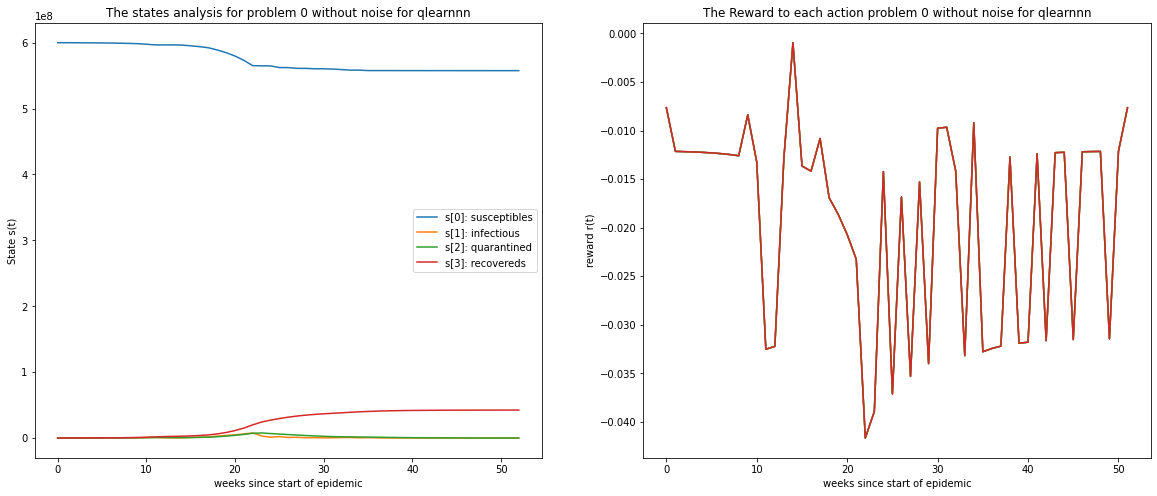

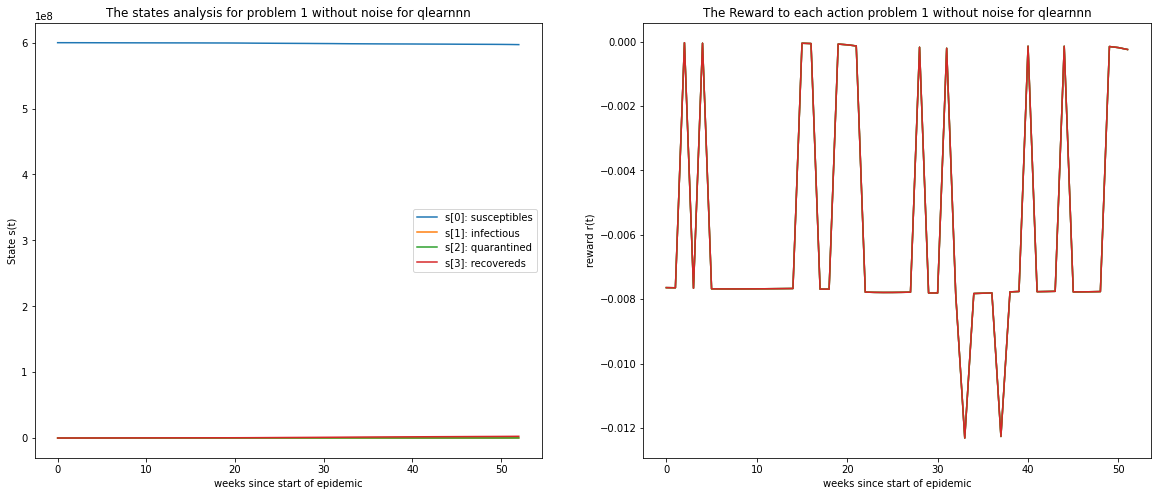

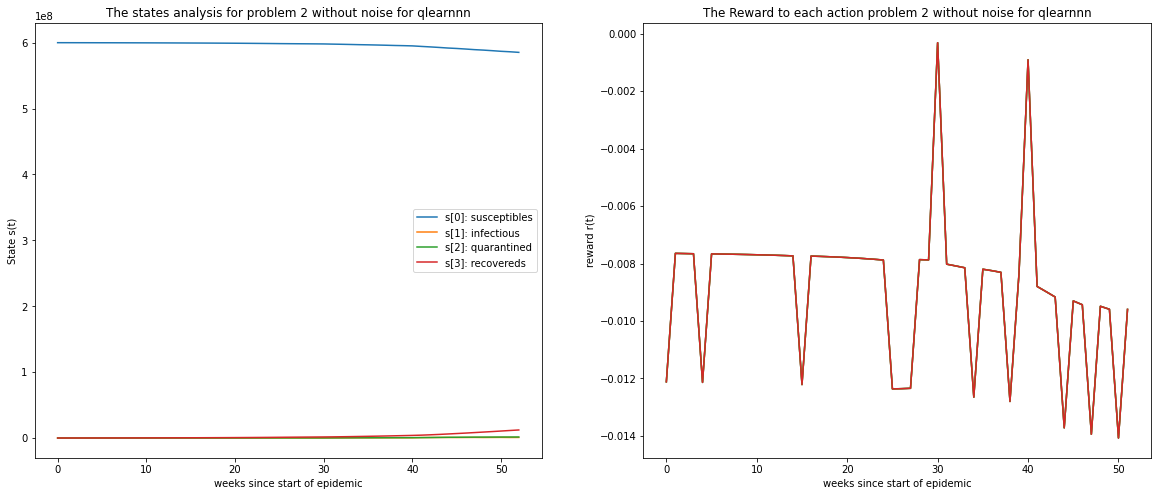

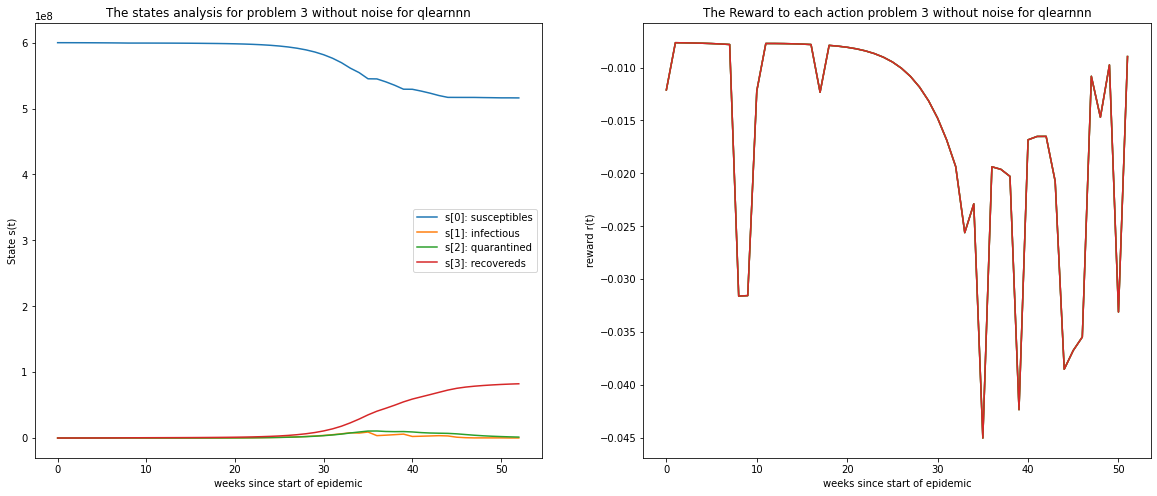

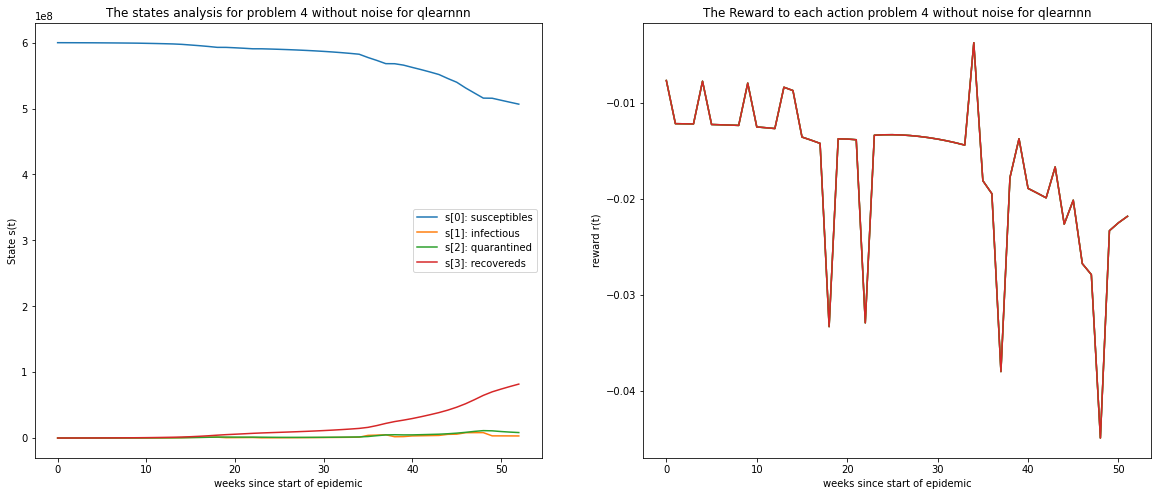

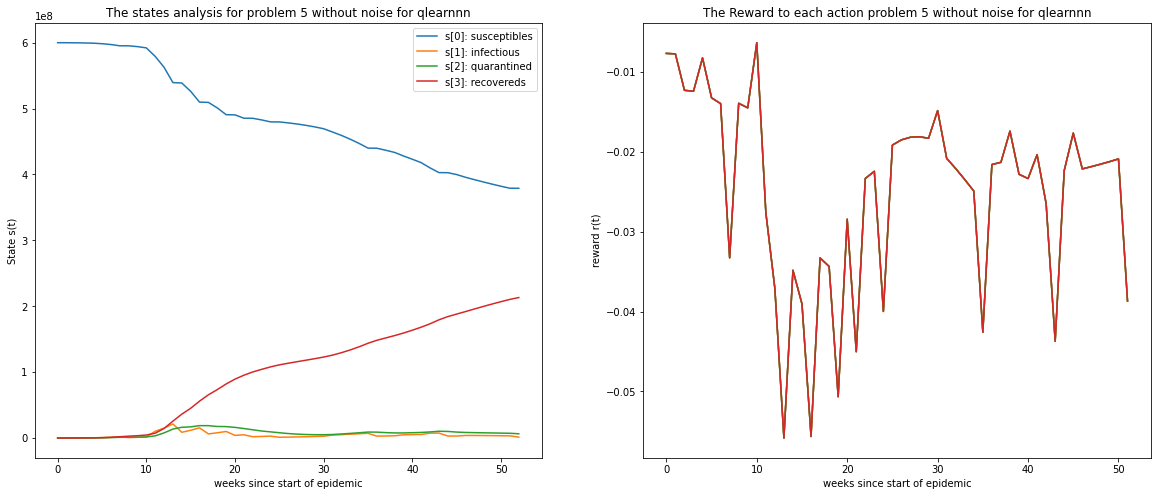

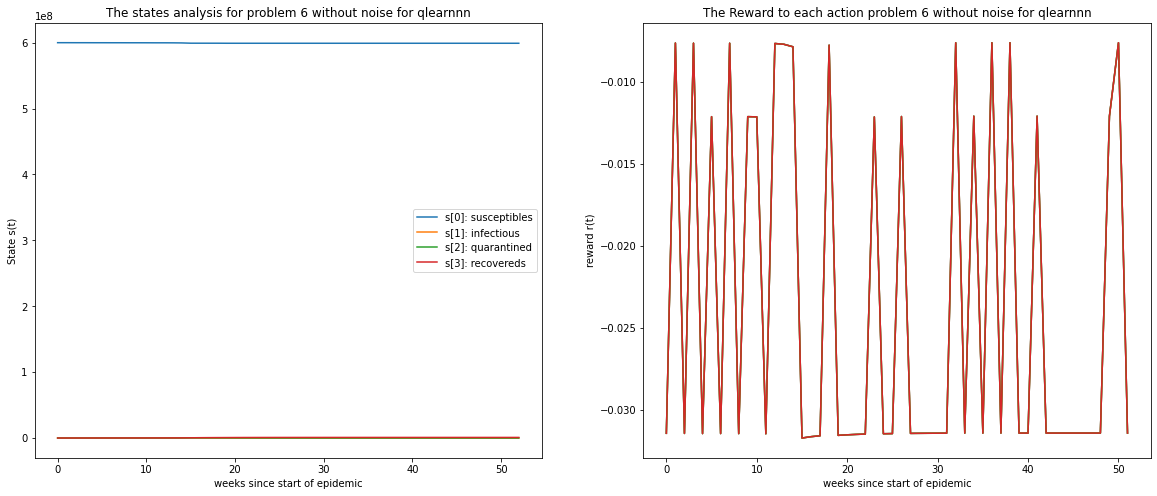

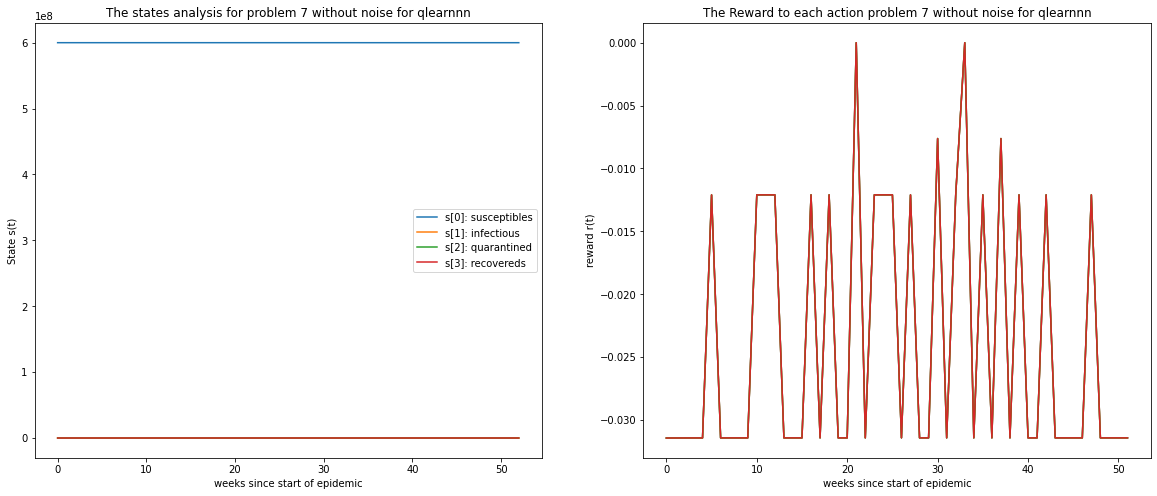

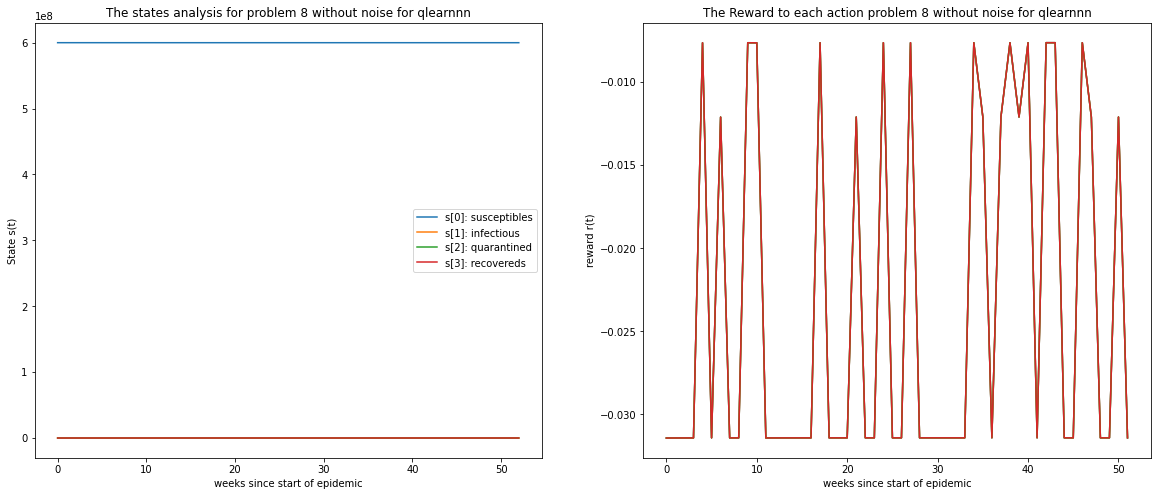

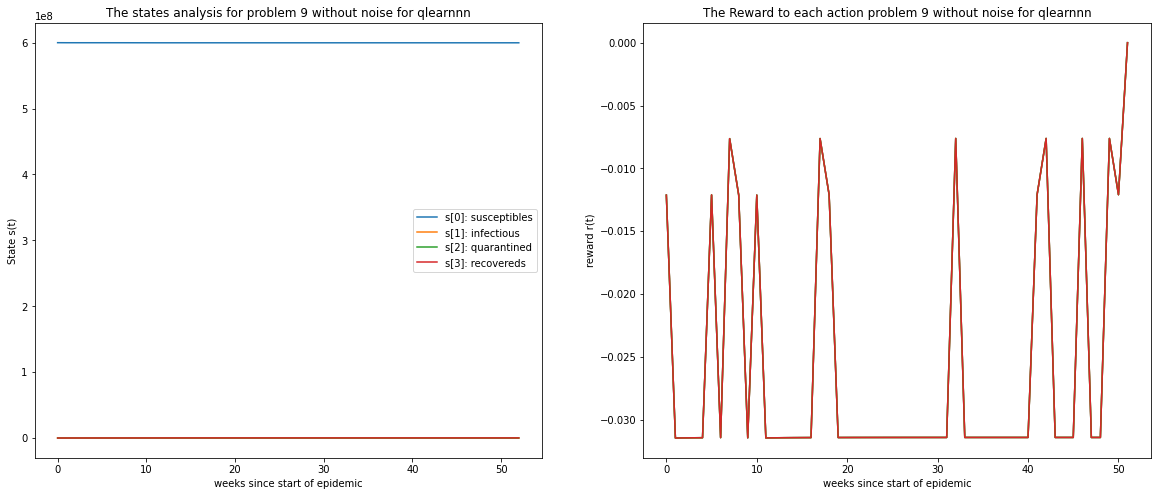

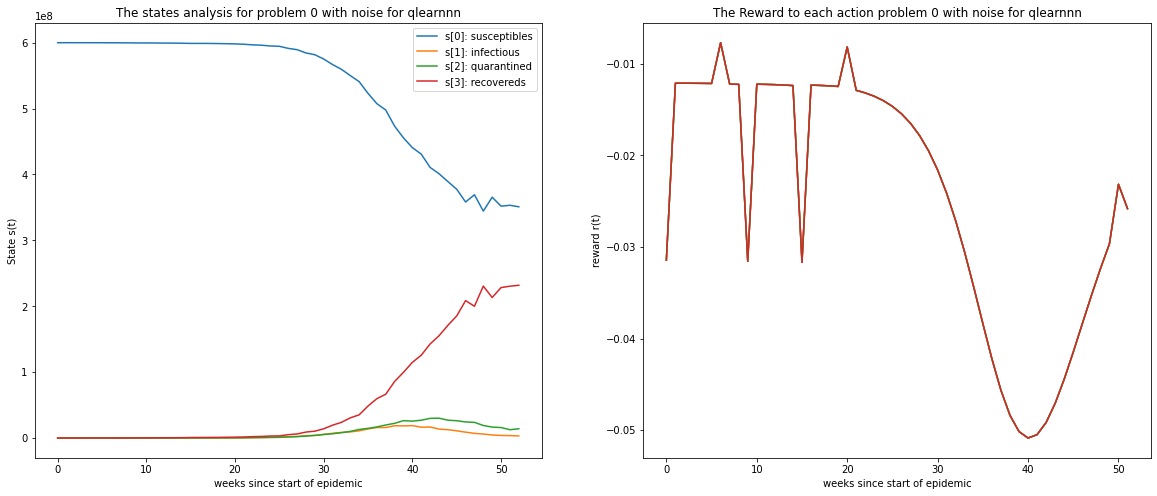

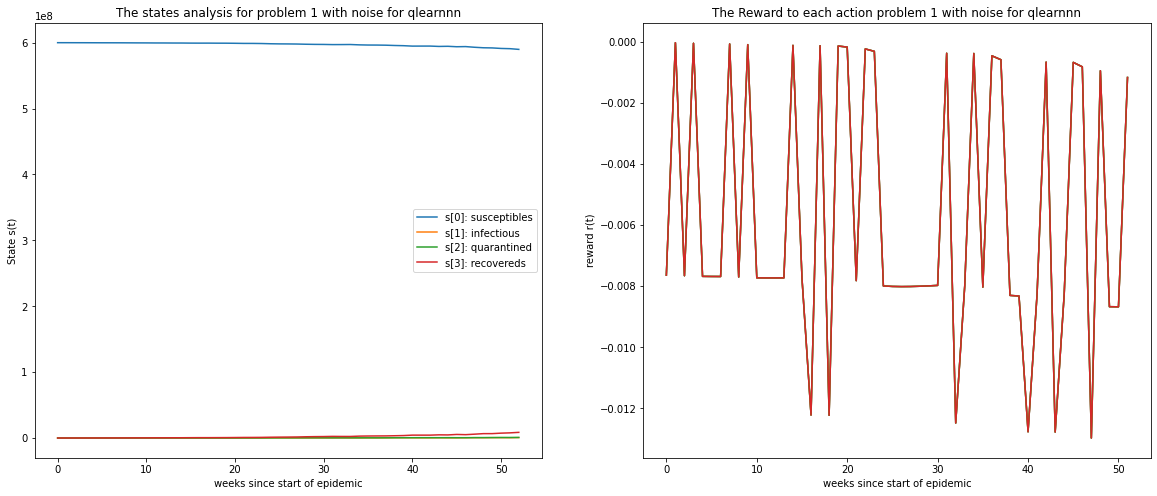

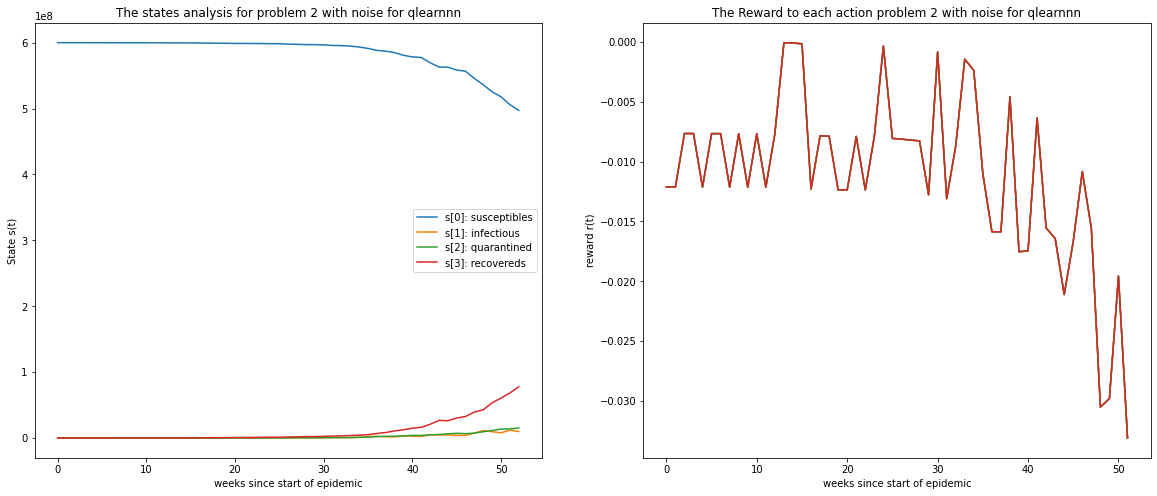

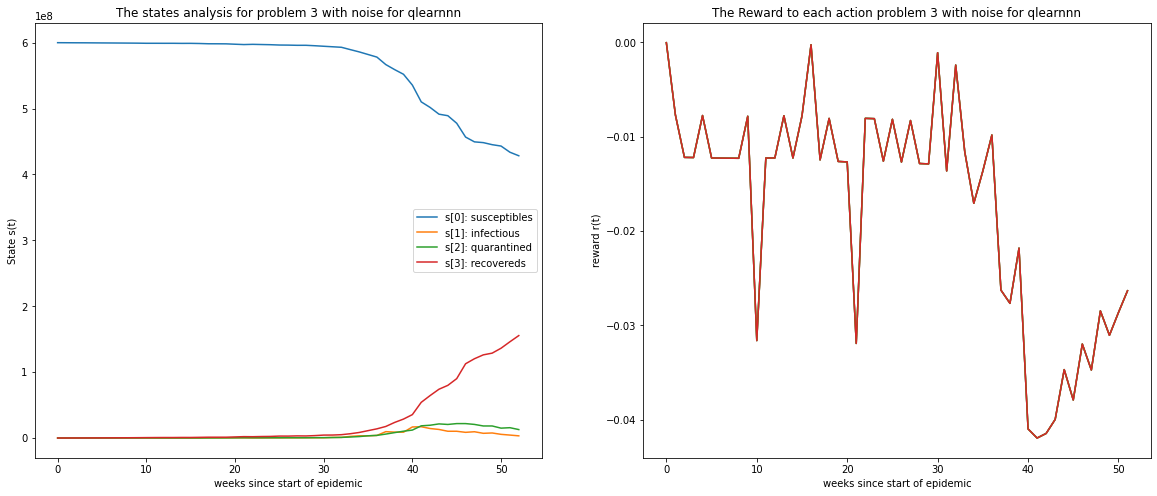

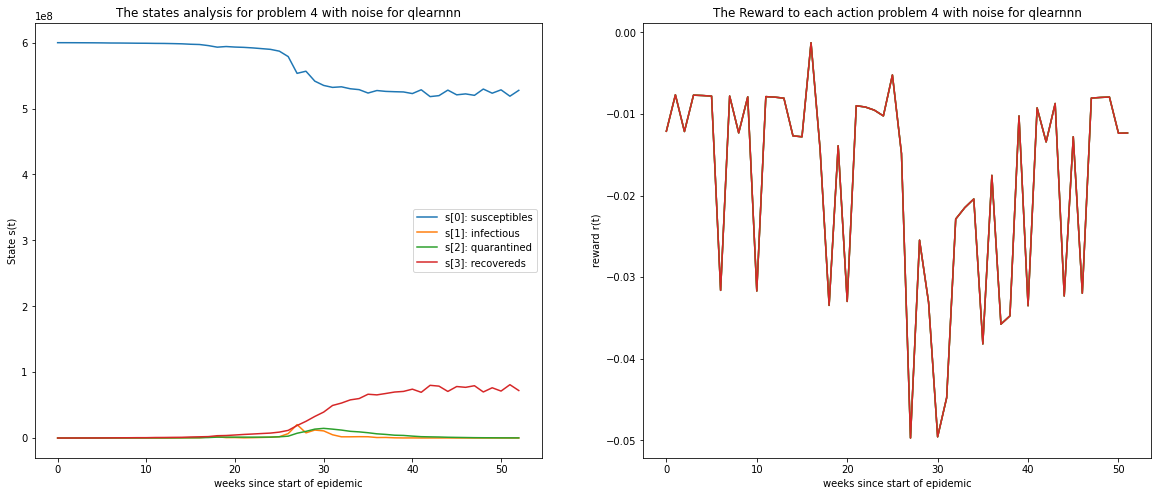

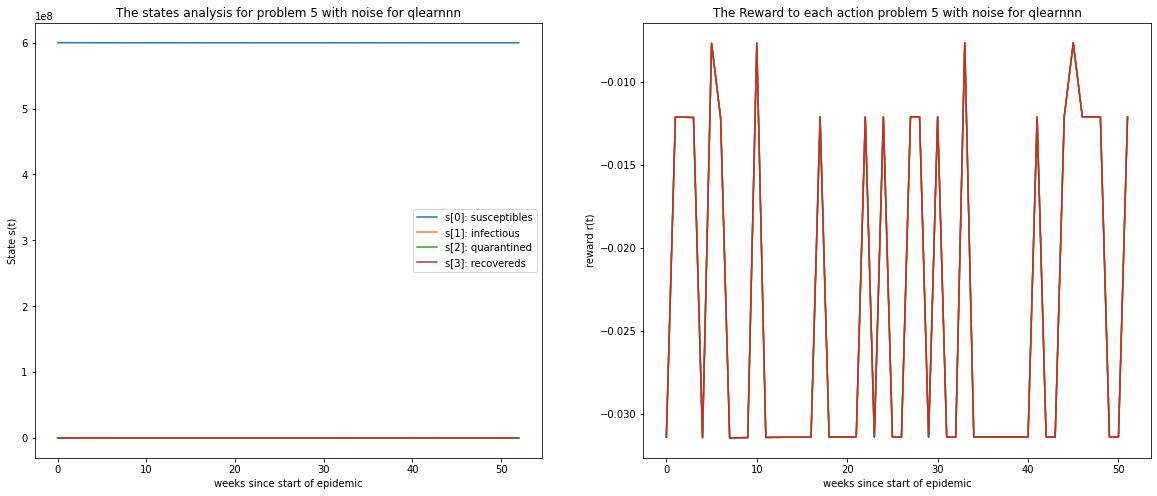

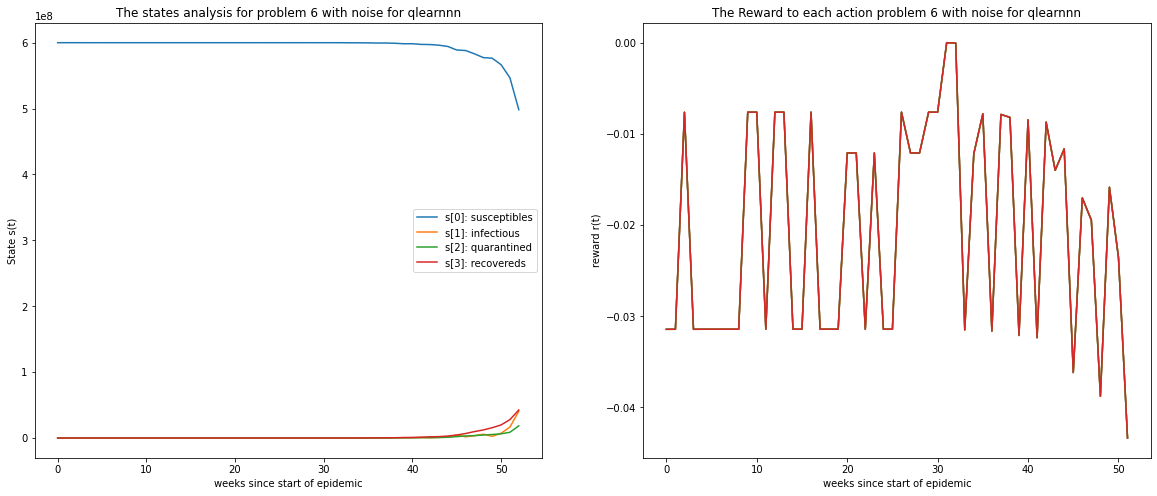

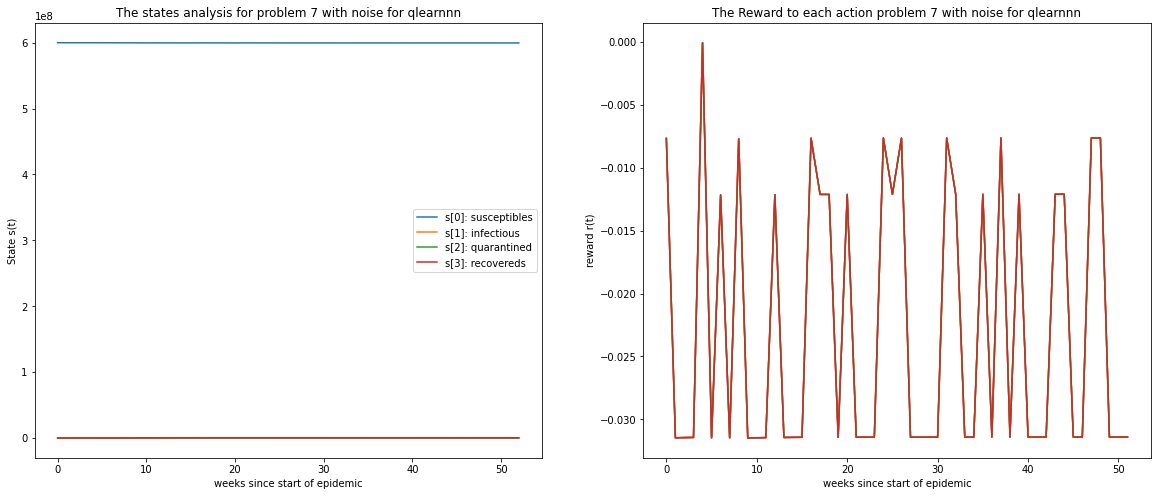

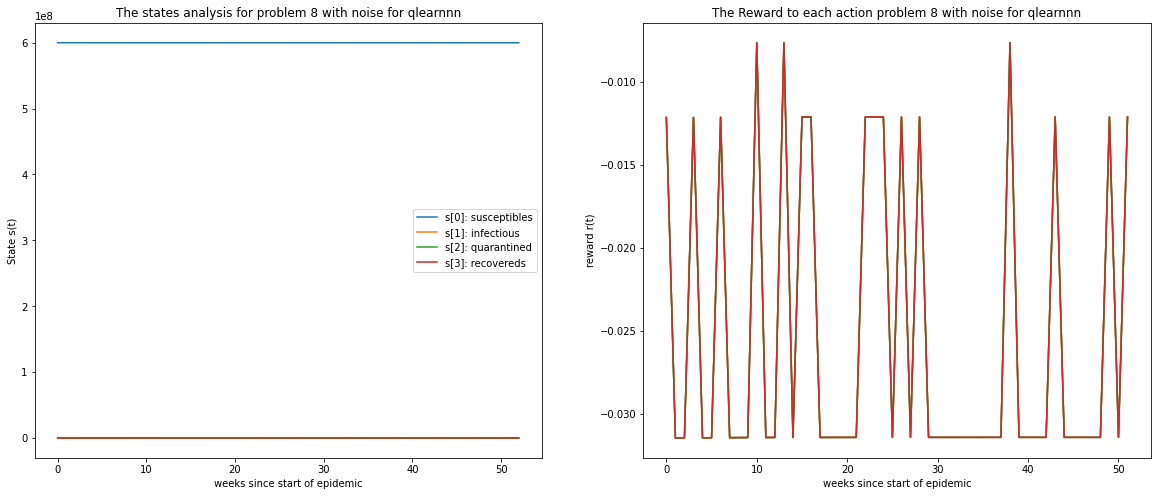

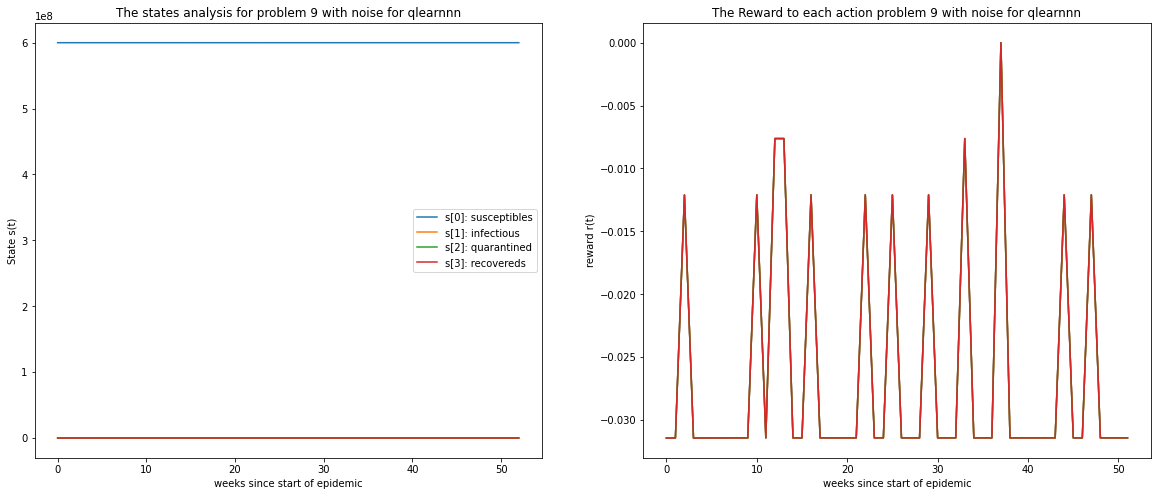

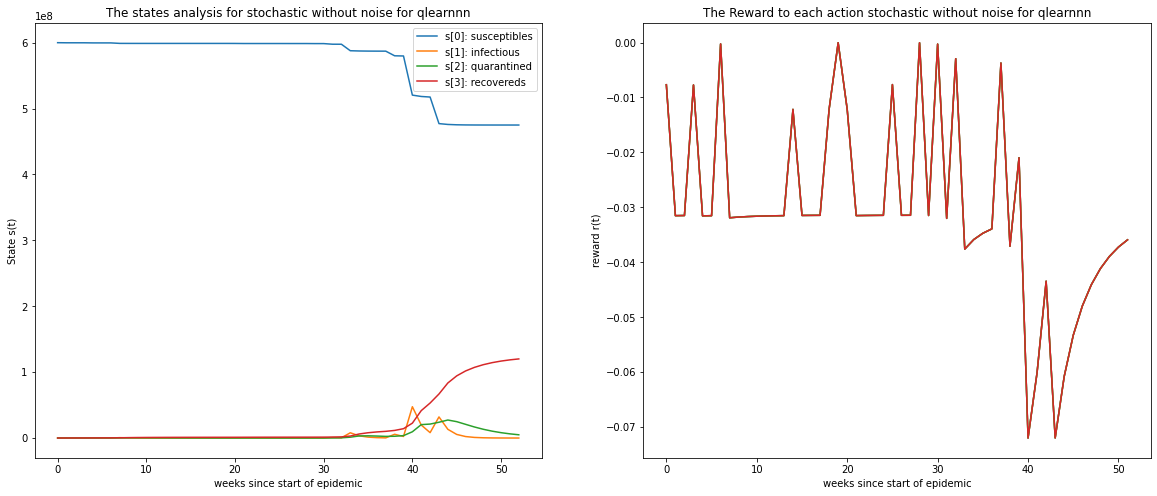

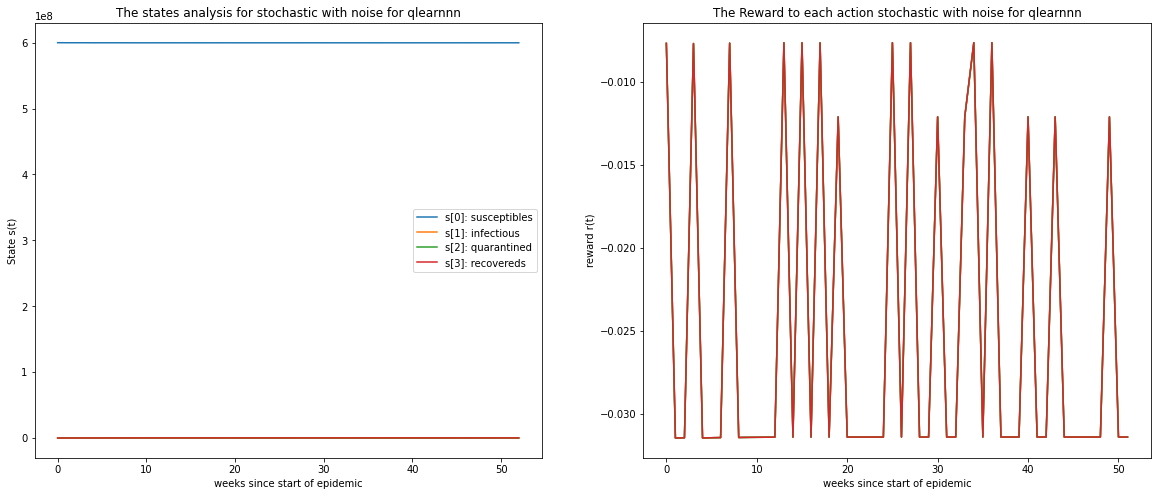

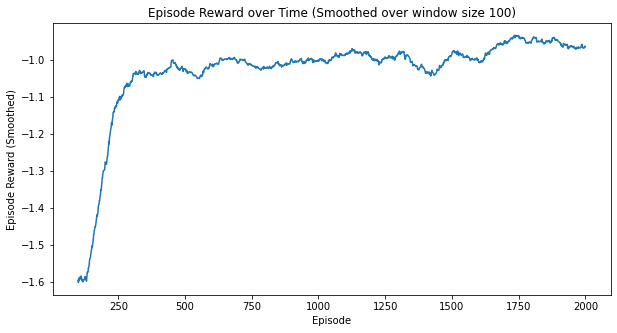

This is the convergence graphs for problem 0 without noise for qlearnnn


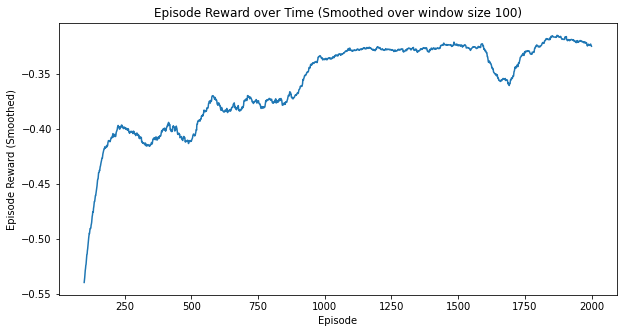

This is the convergence graphs for problem 1 without noise for qlearnnn


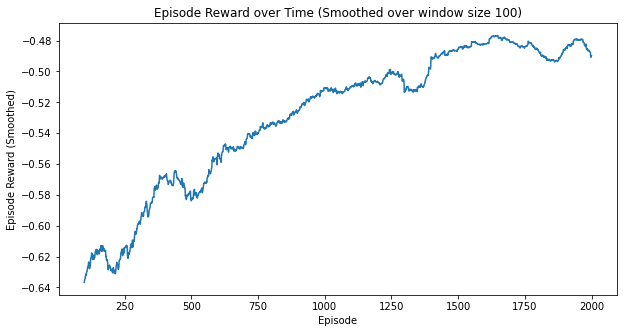

This is the convergence graphs for problem 2 without noise for qlearnnn


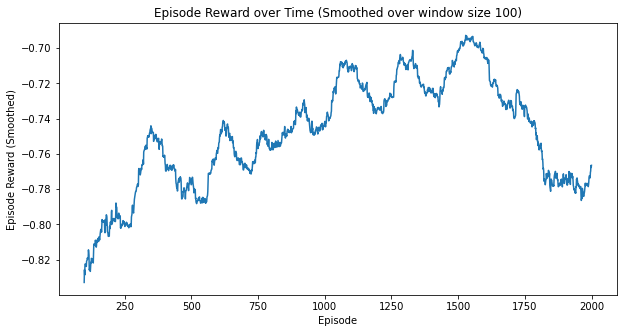

This is the convergence graphs for problem 3 without noise for qlearnnn


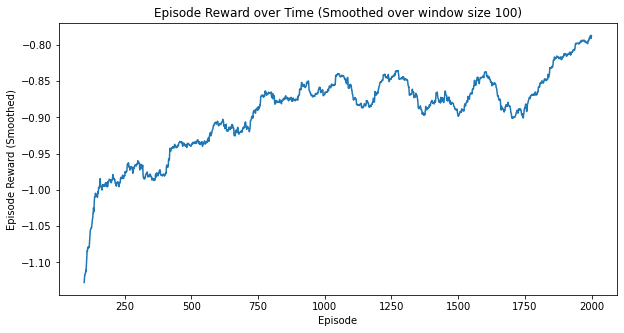

This is the convergence graphs for problem 4 without noise for qlearnnn


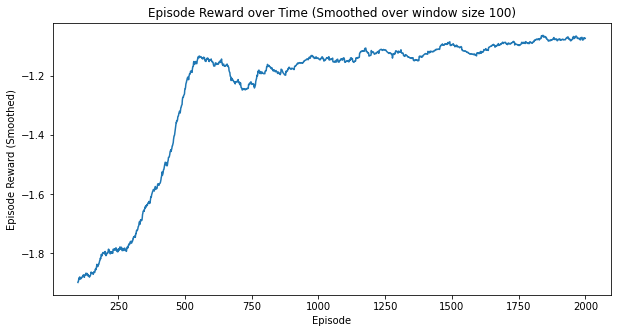

This is the convergence graphs for problem 5 without noise for qlearnnn


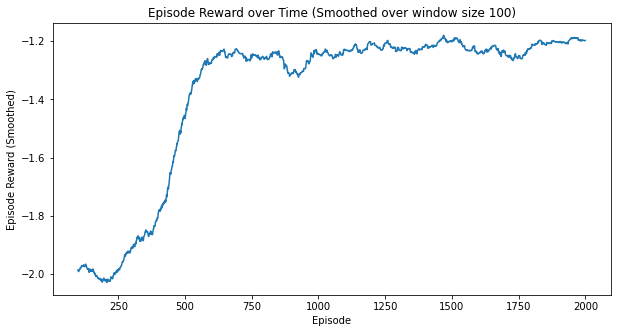

This is the convergence graphs for problem 6 without noise for qlearnnn


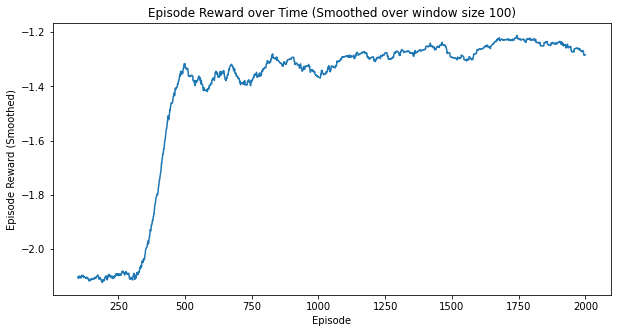

This is the convergence graphs for problem 7 without noise for qlearnnn


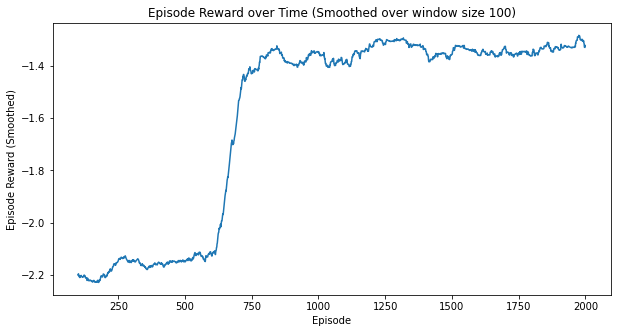

This is the convergence graphs for problem 8 without noise for qlearnnn


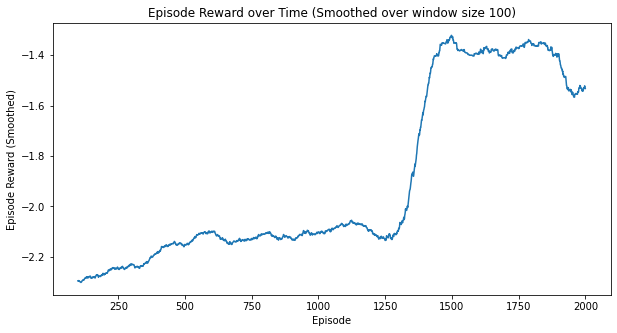

This is the convergence graphs for problem 9 without noise for qlearnnn


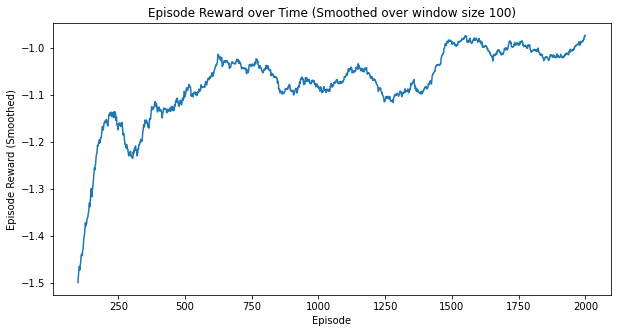

This is the convergence graphs for problem 0 with noise for qlearnnn


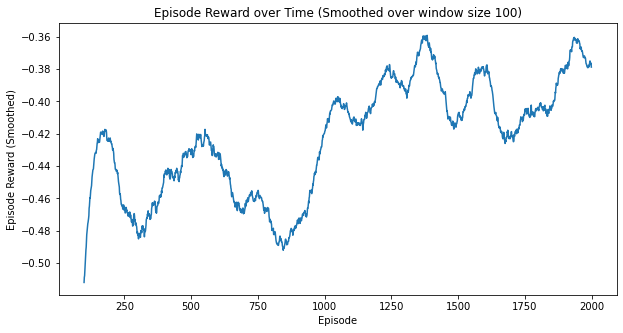

This is the convergence graphs for problem 1 with noise for qlearnnn


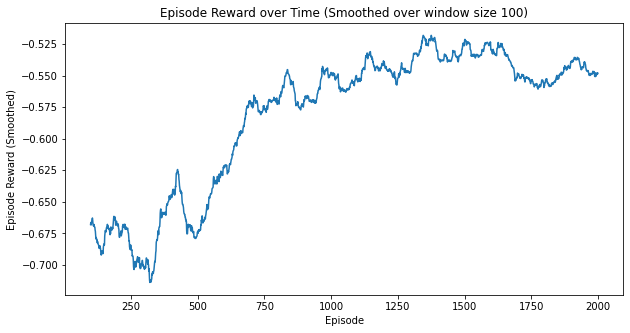

This is the convergence graphs for problem 2 with noise for qlearnnn


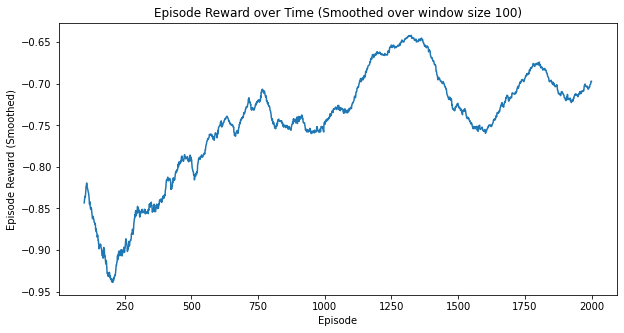

This is the convergence graphs for problem 3 with noise for qlearnnn


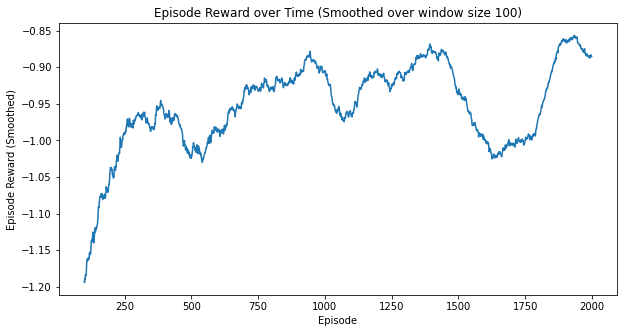

This is the convergence graphs for problem 4 with noise for qlearnnn


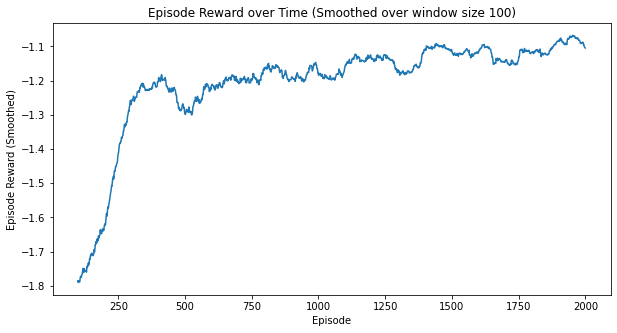

This is the convergence graphs for problem 5 with noise for qlearnnn


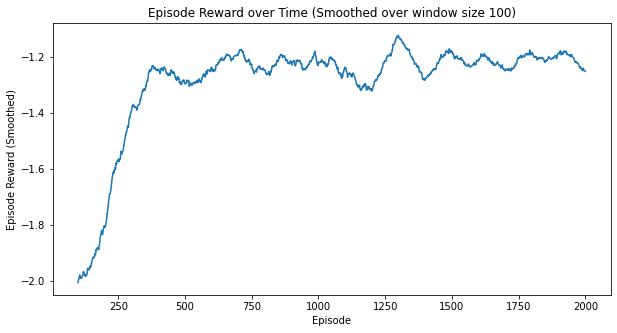

This is the convergence graphs for problem 6 with noise for qlearnnn


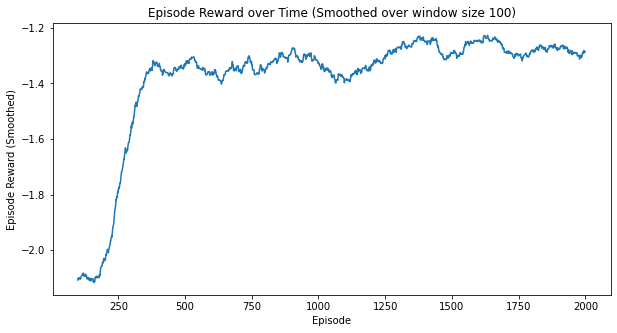

This is the convergence graphs for problem 7 with noise for qlearnnn


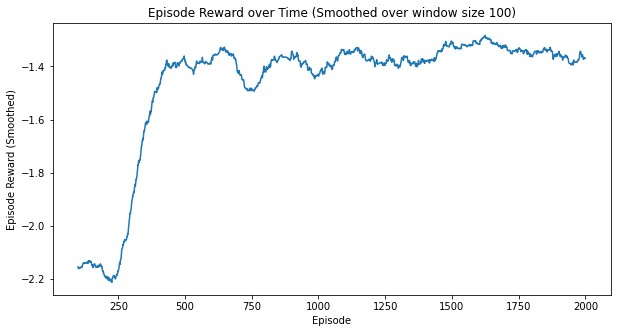

This is the convergence graphs for problem 8 with noise for qlearnnn


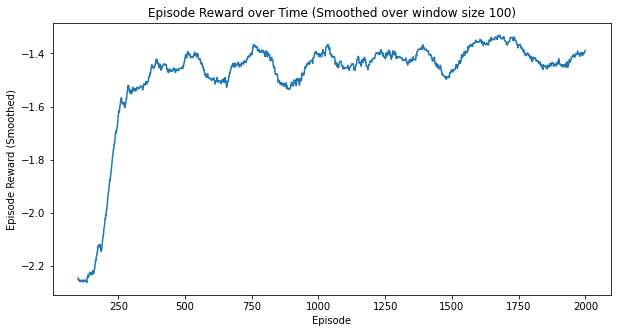

This is the convergence graphs for problem 9 with noise for qlearnnn


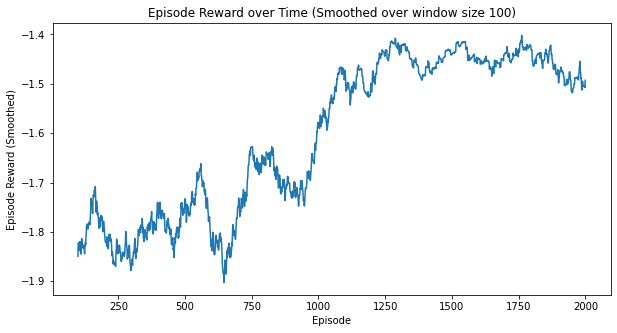

This is the convergence graphs for stochastic environment without noise for qlearnnn


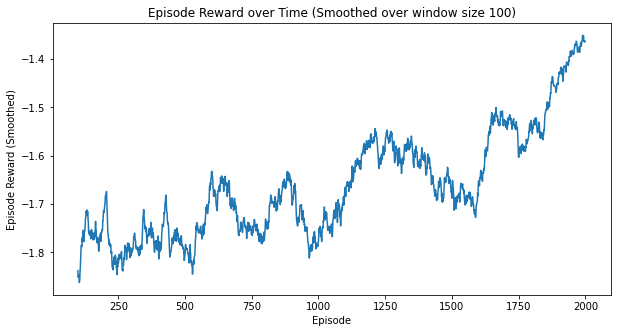

This is the convergence graphs for stochastic environment with noise for qlearnnn


In [13]:
#visualization_for_qlearnnn_agent()